In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('IPN31152N.csv',index_col='DATE',parse_dates=True)

<Axes: xlabel='DATE'>

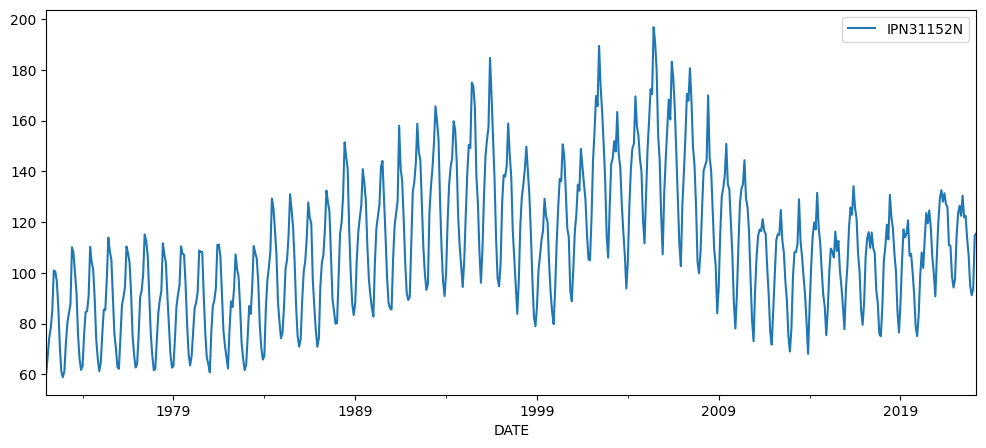

In [4]:
df.plot(figsize=(12,5))

In [5]:
df.head()

,IPN31152N
DATE,
1972-01-01,60.1529
1972-02-01,67.2738
1972-03-01,74.4713
1972-04-01,78.3607
1972-05-01,85.0335


In [6]:
df.columns = ['Production']

## Répartition Entraînement / Test

In [7]:
len(df)

615

In [7]:
len(df)-24

591

In [8]:
test_size = 24
test_ind = len(df)-test_size

In [9]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

## Mise à l'échelle des données

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

In [12]:
# Si warning, ignorez le, cest juste une conversion en float
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train)

MinMaxScaler()

In [13]:
scaler_train = scaler.transform(train)
scaler_test = scaler.transform(test)

## Générateur de séries temporelles

In [14]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# Redéfinissons pour obtenir 12 mois en arrière et prédisons le mois suivant
length = 18
generator = TimeseriesGenerator(scaler_train, scaler_train, length=length, batch_size=1)

In [16]:
# À quoi ressemble le premier batch ?
X,y = generator[0]

In [17]:
print(f"Compte tenu du tableau suivant : \n {X.flatten()}")
print(f'Cela prédit ce y : \n {y}')

Compte tenu du tableau suivant : 
 [0.00946844 0.06107885 0.11324444 0.14143379 0.18979649 0.30491157
 0.30149644 0.27411739 0.19733776 0.08531384 0.0156138  0.
 0.01773956 0.09849312 0.15587563 0.18355909 0.20875512 0.37144363]
Cela prédit ce y : 
 [[0.35419836]]


In [18]:
scaler_train

array([[0.00946844],
       [0.06107885],
       [0.11324444],
       [0.14143379],
       [0.18979649],
       [0.30491157],
       [0.30149644],
       [0.27411739],
       [0.19733776],
       [0.08531384],
       [0.0156138 ],
       [0.        ],
       [0.01773956],
       [0.09849312],
       [0.15587563],
       [0.18355909],
       [0.20875512],
       [0.37144363],
       [0.35419836],
       [0.29812914],
       [0.23970223],
       [0.12102706],
       [0.05289471],
       [0.02087566],
       [0.03141387],
       [0.12131987],
       [0.18620451],
       [0.18853176],
       [0.23180437],
       [0.37259312],
       [0.32887912],
       [0.30805709],
       [0.22407684],
       [0.10933284],
       [0.05452473],
       [0.01750039],
       [0.04077214],
       [0.12185258],
       [0.19275429],
       [0.19219042],
       [0.28135425],
       [0.39892125],
       [0.35979941],
       [0.33565213],
       [0.22869872],
       [0.1240182 ],
       [0.08401142],
       [0.029

## Création du Modèle

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [20]:
# Nous n'utilisons qu'une seule feature dans notre série temporelle
n_features = 1

In [22]:
# définir le modèle
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping et création d'un Générateur de Validation

REMARQUE : la taille de l'ensemble de données scaled_test DOIT être supérieure à la longueur choisie pour vos batchs. Regardez la vidéo pour plus d'informations à ce sujet.

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [26]:
validation_generator = TimeseriesGenerator(scaler_test,scaler_test, length=length, batch_size=1)

In [27]:
# ajustement du modèle
model.fit(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
573/573 [==============================] - 5s 6ms/step - loss: 0.0265 - val_loss: 0.0061
Epoch 2/20
573/573 [==============================] - 4s 6ms/step - loss: 0.0111 - val_loss: 0.0029
Epoch 3/20
573/573 [==============================] - 3s 6ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 4/20
573/573 [==============================] - 3s 6ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 5/20
573/573 [==============================] - 3s 6ms/step - loss: 0.0034 - val_loss: 0.0074
Epoch 6/20
573/573 [==============================] - 3s 6ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 7/20
573/573 [==============================] - 3s 6ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 8/20
573/573 [==============================] - 3s 6ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 9/20
573/573 [==============================] - 3s 6ms/step - loss: 0.0027 - val_loss: 0.0017


In [28]:
losses = pd.DataFrame(model.history.history)

<Axes: >

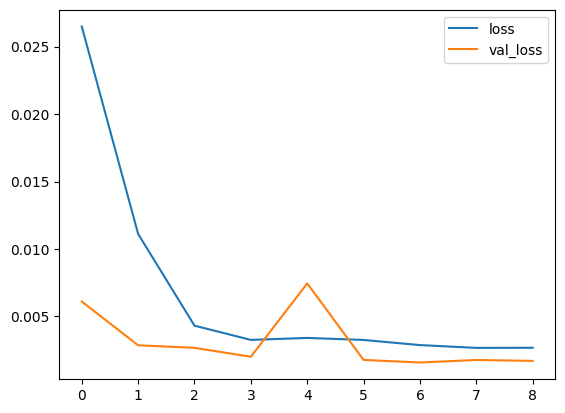

In [29]:
losses.plot()

## Évaluation sur les données de test

In [30]:
# Pensons au premier point batch que je devrai passer dans mon modèle pour prédire quelque chose sur le set de test

first_eval_batch = scaler_train[-length:] #on prend les 50 derniers points de train pour predire le premier point de test

In [31]:
first_eval_batch = first_eval_batch.reshape((1, length, n_features)) #on reshape pour que le modèle puisse le lire

In [32]:
model.predict(first_eval_batch) #on predit le premier point de test

1/1 [==============================] - 0s 206ms/step


array([[0.558771]], dtype=float32)

In [33]:
scaler_test[0] #on compare avec le premier point de test

array([0.5342394])

In [34]:
#boucle pour predire tous les points de test
test_predictions = []
first_eval_batch = scaler_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

In [35]:
first_eval_batch

array([[0.2382034 ],
       [0.14550484],
       [0.11741986],
       [0.17694408],
       [0.28878536],
       [0.35641109],
       [0.31227238],
       [0.39429574],
       [0.46898947],
       [0.43938391],
       [0.47658075],
       [0.42874641],
       [0.34471035],
       [0.29659262],
       [0.23086797],
       [0.34511622],
       [0.44446965],
       [0.51066033]])

In [36]:
predicted_value = [[[52]]] #on initialise predicted_value
np.append(current_batch[:,1:,:],[[[52]]],axis=1) #on prend le dernier point de current_batch et on lui ajoute le point suivant de scaled_train

array([[[ 0.14550484],
        [ 0.11741986],
        [ 0.17694408],
        [ 0.28878536],
        [ 0.35641109],
        [ 0.31227238],
        [ 0.39429574],
        [ 0.46898947],
        [ 0.43938391],
        [ 0.47658075],
        [ 0.42874641],
        [ 0.34471035],
        [ 0.29659262],
        [ 0.23086797],
        [ 0.34511622],
        [ 0.44446965],
        [ 0.51066033],
        [52.        ]]])

In [37]:
test_predictions = []

first_eval_batch = scaler_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 24ms/step


## Transformations inverses et Comparaison

In [38]:
test_predictions

[array([0.558771], dtype=float32),
 array([0.6004454], dtype=float32),
 array([0.59470993], dtype=float32),
 array([0.54275984], dtype=float32),
 array([0.45911312], dtype=float32),
 array([0.36048815], dtype=float32),
 array([0.27580616], dtype=float32),
 array([0.23898849], dtype=float32),
 array([0.28742185], dtype=float32),
 array([0.40263063], dtype=float32),
 array([0.4839924], dtype=float32),
 array([0.5410433], dtype=float32),
 array([0.5892101], dtype=float32),
 array([0.6049346], dtype=float32),
 array([0.56785446], dtype=float32),
 array([0.48899513], dtype=float32),
 array([0.3846487], dtype=float32),
 array([0.27797204], dtype=float32),
 array([0.2003786], dtype=float32),
 array([0.20060936], dtype=float32),
 array([0.29969713], dtype=float32),
 array([0.40264764], dtype=float32),
 array([0.4687581], dtype=float32),
 array([0.51859957], dtype=float32)]

In [39]:
scaler_test

array([[0.5342394 ],
       [0.50161951],
       [0.52567547],
       [0.49443555],
       [0.48659495],
       [0.37762087],
       [0.37557194],
       [0.28772429],
       [0.25639522],
       [0.28046496],
       [0.40039616],
       [0.46663323],
       [0.48980859],
       [0.46119235],
       [0.5187633 ],
       [0.45688212],
       [0.46089302],
       [0.39620335],
       [0.34758553],
       [0.26176869],
       [0.23401204],
       [0.25289094],
       [0.40440996],
       [0.41102859]])

In [40]:
true_predictions = scaler.inverse_transform(test_predictions)

In [41]:
true_predictions

array([[135.94242779],
       [141.69241225],
       [140.90106774],
       [133.73329985],
       [122.19221967],
       [108.58452758],
       [ 96.90060653],
       [ 91.82072167],
       [ 98.5032714 ],
       [114.39909841],
       [125.62491549],
       [133.49645983],
       [140.1422323 ],
       [142.31180329],
       [137.19570861],
       [126.31516363],
       [111.91805965],
       [ 97.1994424 ],
       [ 86.49355655],
       [ 86.52539537],
       [100.19694191],
       [114.40144634],
       [123.52297783],
       [130.3998089 ]])

In [42]:
test['Predictions'] = true_predictions

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9528\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [43]:
test

,Production,Predictions
DATE,,
2021-04-01,132.5577,135.942428
2021-05-01,128.0570,141.692412
2021-06-01,131.3761,140.901068
2021-07-01,127.0658,133.733300
2021-08-01,125.9840,122.192220
2021-09-01,110.9484,108.584528
2021-10-01,110.6657,96.900607
2021-11-01,98.5450,91.820722
2021-12-01,94.2224,98.503271


<Axes: xlabel='DATE'>

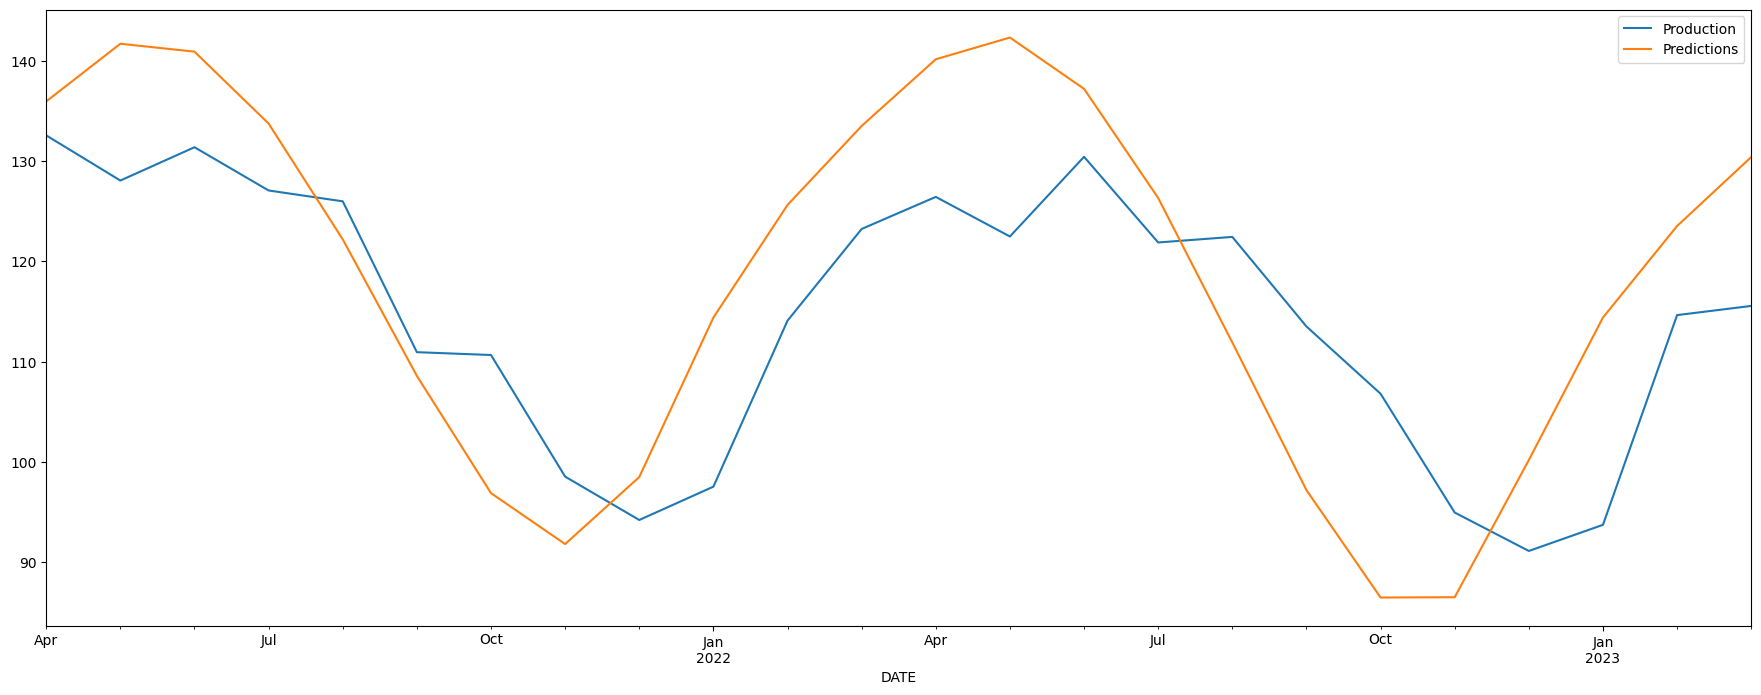

In [44]:
test.plot(figsize=(22,8))

## Ré-Entraînement et Prévision

In [45]:
full_scaler = MinMaxScaler()

In [46]:
scaler_full_data = full_scaler.fit_transform(df)

In [47]:
length = 12
generator = TimeseriesGenerator(scaler_full_data,scaler_full_data,length=length,batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(100, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(generator,epochs=12)